### scVI and SCCAF data integration and clustering analysis of healthy PBMC [Cai20_22]

**Objective**: Run complete integration and clustering analysis after solving scanpy/scVI dependency issues and incorporate Yoshida et al 2021 data

**Developed by**: Mairi McClean

**Institute of Computational Biology - Helmholtz Zentrum Munich**

**v230425**


In [1]:
%pip install --quiet scvi-colab
%pip install --quiet scib-metrics
from scvi_colab import install

install()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Users/mairi.mcclean/mambaforge/envs/scvi_sccaf_py39/lib/python3.9/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import sys
import scvi
import torch
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/scvi_sccaf_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mairi.mcclean/mambaforge/envs/scvi_sccaf_py39/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scvi_sccaf_py39/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scvi_sccaf_py39/lib/python3.9/site-packa

In [3]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Read in datasets for integration
> Cai 2020 + Cai 2022

### Read in datasets

- Read in _Cai Y et al 2020_

In [4]:
caiy2020 = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/processed_files/abridged_qc/human/Cai2020_scRNA_PBMC_mm230315_qcd.h5ad')
caiy2020

AnnData object with n_obs × n_vars = 73146 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [5]:
# file path from local machine
# caiy2020 = sc.read_h5ad('/Users/mairi.mcclean/data/abridged_qc/human/Cai2020_scRNA_PBMC_mm230315_qcd.h5ad')
# caiy2020

In [6]:
caiy2020.obs['status'].value_counts()

status
active_TB    33104
Healthy      22049
latent_TB    17993
Name: count, dtype: int64

- Read in _Cai Y et al 2022_

In [7]:
caiy2022 = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/processed_files/abridged_qc/human/Cai2022_scRNA_PBMC_mm230315_qcd.h5ad')

# file path for local machine
# caiy2022 = sc.read_h5ad('/Users/mairi.mcclean/data/abridged_qc/human/Cai2022_scRNA_PBMC_mm230315_qcd.h5ad')

caiy2022.obs['status'] = 'active_TB'
caiy2022

AnnData object with n_obs × n_vars = 25417 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'status'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [8]:
# So Cai2022 has no healthy controls? Publication suggests that all samples were taken from either TPE, pneumonia, or lung cancer

caiy2022.obs['status'].value_counts()

status
active_TB    25417
Name: count, dtype: int64

- Subset healthy donors from Cai data
> Cai_2022 has no healthy donors; will be discarded


In [9]:
caiy2020.obs

,study,individual,sample,tissue,donor,age,gender,status,data_type,centre,...,pct_counts_mt,total_counts_ribo,pct_counts_ribo,percent_mt2,n_counts,percent_chrY,XIST-counts,S_score,G2M_score,predicted_doublets
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAACAATC-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,6.017039,1676.0,29.747959,0.060170,5634.0,0.053248,0.0,-0.352188,-0.193287,0.0
AAACCTGAGAAGGTGA-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,1.668552,1901.0,53.761311,0.016686,3536.0,0.113122,0.0,-0.064944,-0.071169,0.0
AAACCTGAGATCTGCT-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,9.967497,367.0,19.880823,0.099675,1846.0,0.054171,0.0,-0.231399,-0.080643,0.0
AAACCTGAGCACAGGT-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,4.557977,772.0,19.333836,0.045580,3993.0,0.075131,0.0,-0.227884,-0.258770,0.0
AAACCTGAGCGTGAAC-acTB3,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,2.457002,1003.0,49.287468,0.024570,2035.0,0.147420,0.0,0.020959,0.025030,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCGCGGTT-H1,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,3.250689,1904.0,52.451790,0.032507,3630.0,0.110193,0.0,-0.165353,-0.250572,0.0
TTTGTCAGTCGCTTCT-H1,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,4.287570,868.0,37.592033,0.042876,2309.0,0.043309,0.0,-0.177318,-0.173327,0.0
TTTGTCAGTTCGAATC-H1,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,6.650446,712.0,28.872669,0.066504,2466.0,0.040551,0.0,-0.235875,-0.013744,0.0


In [10]:
caiy2020.obs['data_type'].value_counts()

data_type
scRNAseq    73146
Name: count, dtype: int64

In [11]:
caiy2020.obs['tissue'].value_counts()

tissue
PBMC    73146
Name: count, dtype: int64

In [12]:
caiy2020.obs['status'].value_counts()

status
active_TB    33104
Healthy      22049
latent_TB    17993
Name: count, dtype: int64

In [13]:
caiy_healthy = caiy2020[~caiy2020.obs['status'].isin(['active_TB', 'latent_TB']),:]

In [14]:
caiy_healthy.obs['status'].value_counts()

status
Healthy    22049
Name: count, dtype: int64

- Read in _Yoshida et al 2021_

In [15]:
adata_yoshida = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/INBOX/sc_downloads/yoshida_2021/meyer_nikolic_covid_pbmc.cellxgene.20210813.h5ad')
adata_yoshida

AnnData object with n_obs × n_vars = 422220 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [16]:
adata_yoshida.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.359517
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.577522
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Male,Non-smoker,AN3,CV001_KM10202384-CV001_KM10202394,0.369143
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.785563
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.564174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S28_TTTGTCAGTTCTGTTT-1,PC9,EUR,27.17,NK,NK,NK,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.429398
S28_TTTGTCATCAACCAAC-1,PC9,EUR,27.17,Monocyte,Monocyte CD14,Classical monocyte,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.677910
S28_TTTGTCATCATTATCC-1,PC9,EUR,27.17,Monocyte,Monocyte CD14,Classical monocyte,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.422796
S28_TTTGTCATCCTATGTT-1,PC9,EUR,27.17,DC,pDC,pDC,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.471905


In [17]:
adata_yoshida.obs['COVID_status'].value_counts()

COVID_status
Healthy          173684
COVID-19         151312
Post-COVID-19     97224
Name: count, dtype: int64

- Subset healthy Yoshida data 

In [18]:
yoshida_healthy = adata_yoshida[~adata_yoshida.obs['COVID_status'].isin(['COVID-19', 'Post-COVID-19']),:]

In [19]:
yoshida_healthy.obs['COVID_status'].value_counts()

COVID_status
Healthy    173684
Name: count, dtype: int64

- Merge _Cai_ and _Yoshida_ data

In [20]:
adata_healthy = caiy_healthy.concatenate(yoshida_healthy, batch_key = 'dataset', batch_categories = ['caiy2022', 'yoshida2021'], join = 'inner')
adata_healthy

AnnData object with n_obs × n_vars = 195733 × 22792
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'dataset'
    var: 'gene_id-caiy2022', 'mt-caiy2022', 'ribo-caiy2022', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022', 'name-yoshida2021'

In [21]:
adata_healthy.obs

,study,individual,sample,tissue,donor,age,gender,status,data_type,centre,...,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight,dataset
AAACCTGAGATGGCGT-H2-caiy2022,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2022
AAACCTGAGATGTGTA-H2-caiy2022,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2022
AAACCTGAGCAACGGT-H2-caiy2022,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2022
AAACCTGAGCCATCGC-H2-caiy2022,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2022
AAACCTGAGGTGATTA-H2-caiy2022,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S22_TTTGTCAGTCGCATCG-1-yoshida2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.343914,yoshida2021
S22_TTTGTCAGTGTAAGTA-1-yoshida2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.264285,yoshida2021
S22_TTTGTCATCATGTCCC-1-yoshida2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.353094,yoshida2021
S22_TTTGTCATCGAGGTAG-1-yoshida2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.611991,yoshida2021


### Calculate HVGs

In [22]:
adata = adata_healthy.copy()
adata.layers['counts'] = adata.X.copy()

In [23]:
sc.pp.highly_variable_genes(adata,
    flavor = "seurat_v3", 
    n_top_genes = 3000, 
    layer = "counts", 
    batch_key = "dataset", 
    subset = True
)

#### Remove unrequired variables prior to model run

In [24]:
del caiy2020
del caiy2022
del adata_yoshida

### Integration with scVI


In [25]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="dataset")

In [26]:
vae = scvi.model.SCVI(adata, n_layers=3, n_latent=50, gene_likelihood="nb", dispersion="gene-batch")

In [27]:
scvi.model.SCVI.view_anndata_setup(vae)

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'dataset',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   2    │
│         n_cells          │ 195733 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │  caiy2022   │          0          │
│                      │ yoshida2021 │          1          │
└──────────────────────┴─────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [28]:
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 41/41: 100%|██████████| 41/41 [59:18<00:00, 61.60s/it, loss=897, v_num=1] 

`Trainer.fit` stopped: `max_epochs=41` reached.


Epoch 41/41: 100%|██████████| 41/41 [59:18<00:00, 86.80s/it, loss=897, v_num=1]


In [29]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [30]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_scVI")
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata, min_dist=0.5, spread=8, random_state=0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [31]:
# adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

In [32]:
plt.figure(figsize = (5, 5))

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

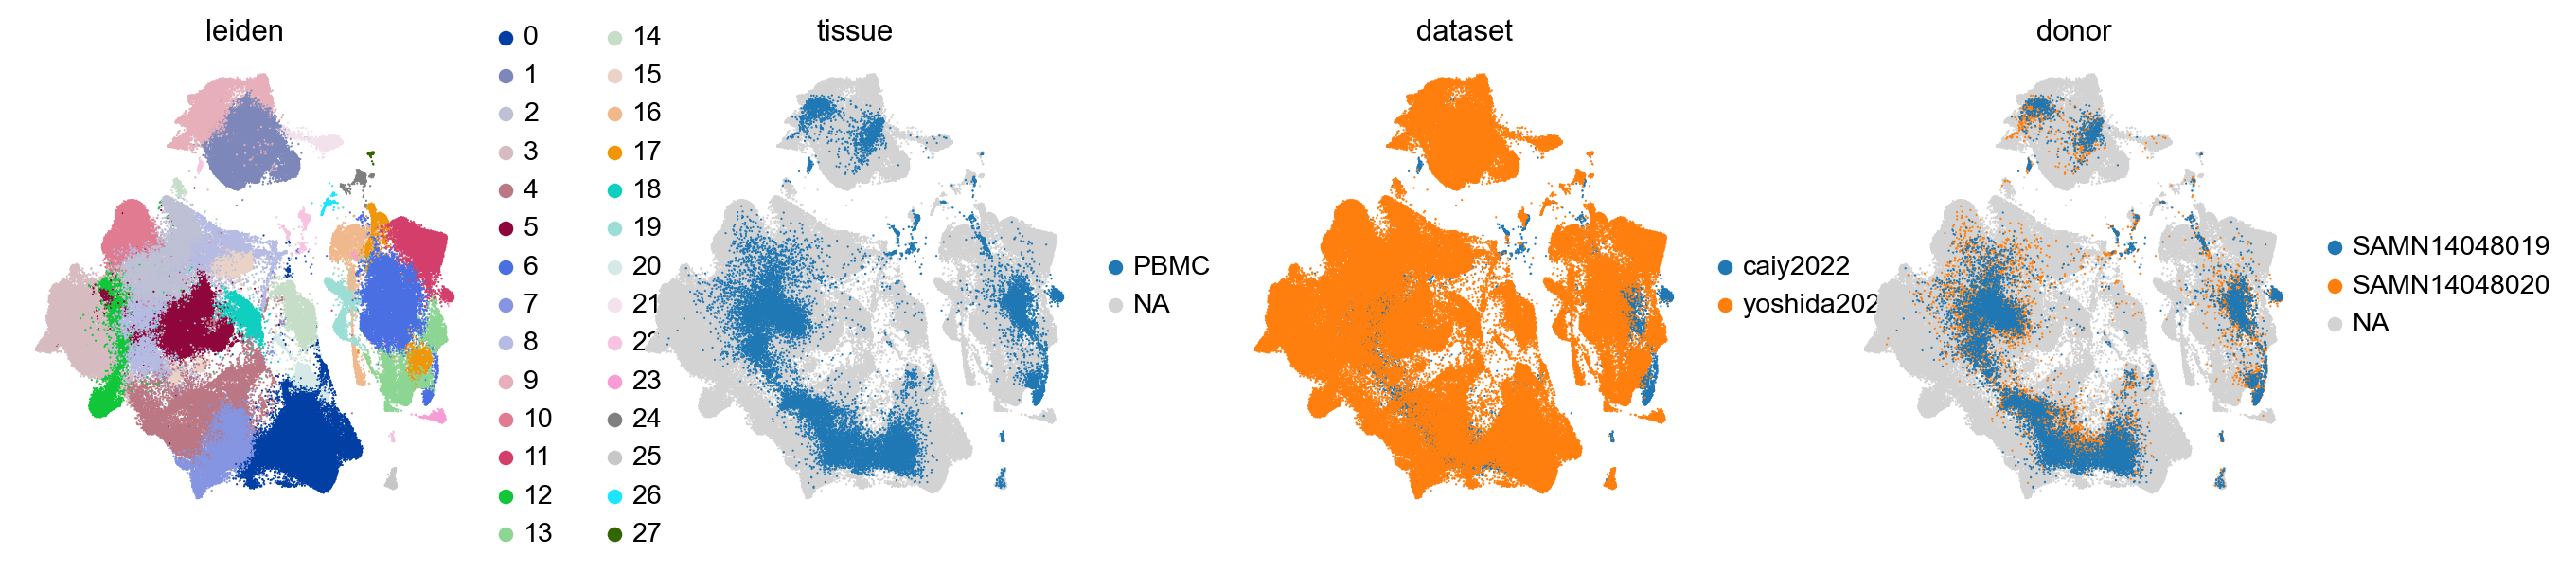

In [33]:
sc.pl.umap(
    adata,
    color=["leiden", "tissue", "dataset", "donor"],
    frameon=False,
    ncols=4,
    size=4
)


### SCCAF clustering analysis

In [34]:
import SCCAF as sccaf
from SCCAF import SCCAF_assessment, plot_roc

In [74]:
# Resolution on a scale from 0 to 1

sc.tl.leiden(adata, resolution = 1.0, random_state = 1786)

In [75]:
# clf ? 
# cvsm ?

y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)



Mean CV accuracy: 0.8297
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.7789


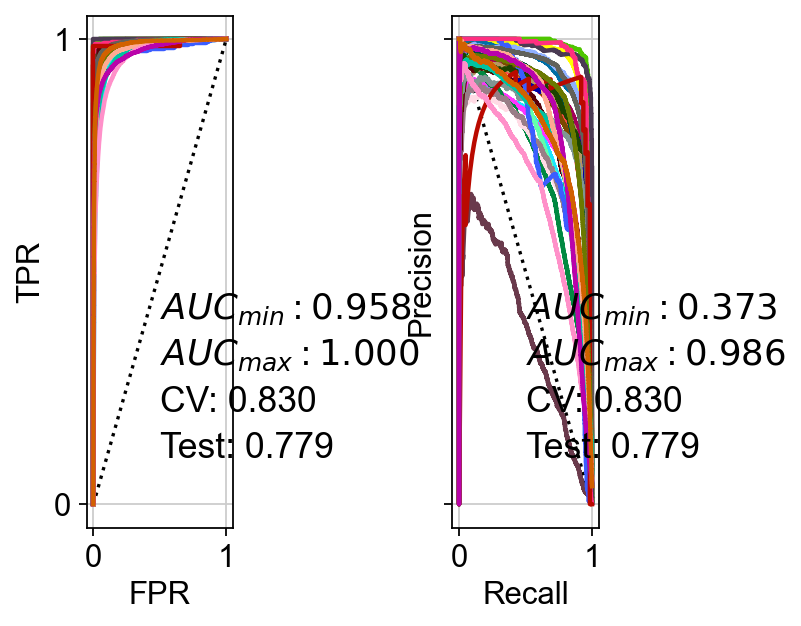

In [76]:
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=1.5,
                    hspace=1.5)

plt.show()

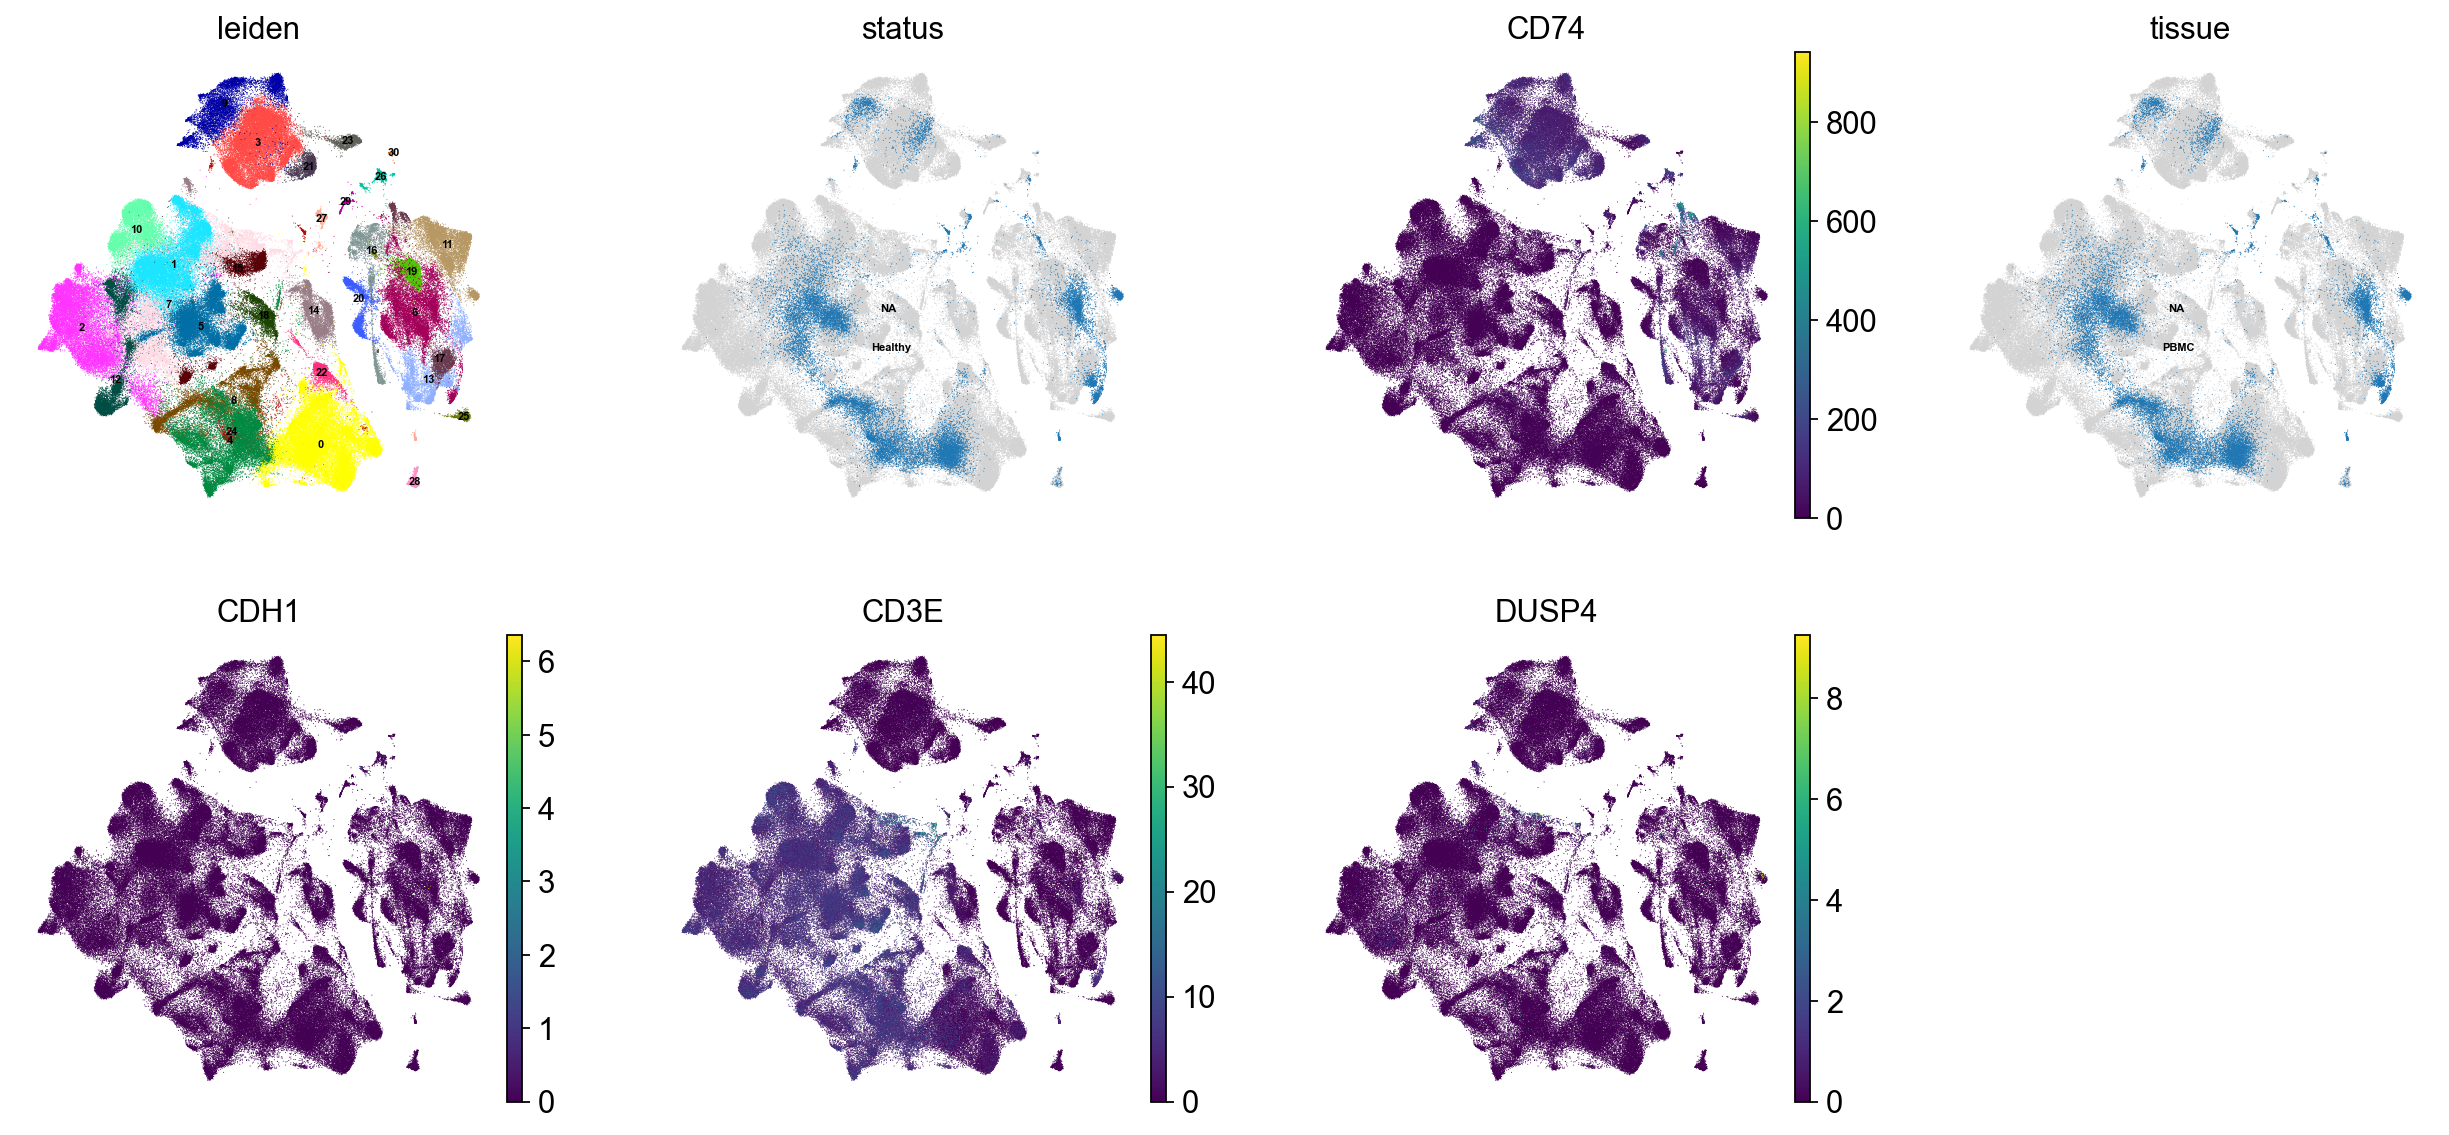

In [77]:
# Markers chosen here are of interest in healthy blood cells
# Removed due to "could not find" error: 'FOXI1'

sc.pl.umap(adata, frameon = False, color = ['leiden', 'status', 'CD74', 'tissue', 'CDH1', 'CD3E', 'DUSP4'], size = 0.8, legend_fontsize = 5, legend_loc = 'on data')

### Export clustered object

In [80]:
adata

AnnData object with n_obs × n_vars = 195733 × 3000
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'dataset', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_id-caiy2022', 'mt-caiy2022', 'ribo-caiy2022', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022', 'name-yoshida2021', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_

In [81]:
caiy_healthy

View of AnnData object with n_obs × n_vars = 22049 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [79]:
# Making a hybrid anndata object using sections from both original anndata object and the cai_tb_gex object
adata_export = anndata.AnnData(X = caiy_healthy.X, var = caiy_healthy.var, obs = adata.obs, uns = adata.uns, obsm = adata.obsm, layers = caiy_healthy.layers, obsp = adata.obsp)
adata_export

ValueError: Value passed for key 'X_scVI' is of incorrect shape. Values of obsm must match dimensions (0,) of parent. Value had shape (195733,) while it should have had (22049,).

In [41]:
adata_export.write('/Volumes/Lacie/data_lake/Mairi_example/processed_files/scvi/post_sccaf/CaiY_Yoshida_healthy_scRNA_PBMC_mm230425_scVI-clustered.raw.h5ad')
